<a href="https://colab.research.google.com/github/zboraon/anthropocene_date/blob/main/anthropocene_changepoint_for_scps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary libraries



Install and load the necessary libraries.


In [1]:
system("apt install -y jags")
system("apt install -y r-base")

In [2]:
list.of.packages <- c("runjags", "RCurl", "mcp", "truncnorm", "coda", "dplyr", "ggplot2", "HDInterval")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, dependencies = TRUE)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘timeDate’, ‘timeSeries’, ‘gss’, ‘rmutil’, ‘clue’, ‘Rcpp’, ‘abind’, ‘tensorA’, ‘distributional’, ‘plyr’, ‘numDeriv’, ‘quadprog’, ‘svUnit’, ‘fBasics’, ‘stable’, ‘stabledist’, ‘statip’, ‘hunspell’, ‘globals’, ‘listenv’, ‘parallelly’, ‘checkmate’, ‘matrixStats’, ‘ggridges’, ‘posterior’, ‘reshape2’, ‘ggdist’, ‘arrayhelpers’, ‘rjags’, ‘modeest’, ‘markdown’, ‘spelling’, ‘bitops’, ‘XML’, ‘future’, ‘future.apply’, ‘loo’, ‘bayesplot’, ‘tidybayes’, ‘patchwork’, ‘hexbin’




In [3]:
rm(list = ls())


In [4]:
library("runjags")
library("RCurl")
library("coda")
library("dplyr")
library("mcp")
library("truncnorm")
library("ggplot2")
library("HDInterval")  # For HDI calculation
set.seed(2018)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Loading and tidying the data

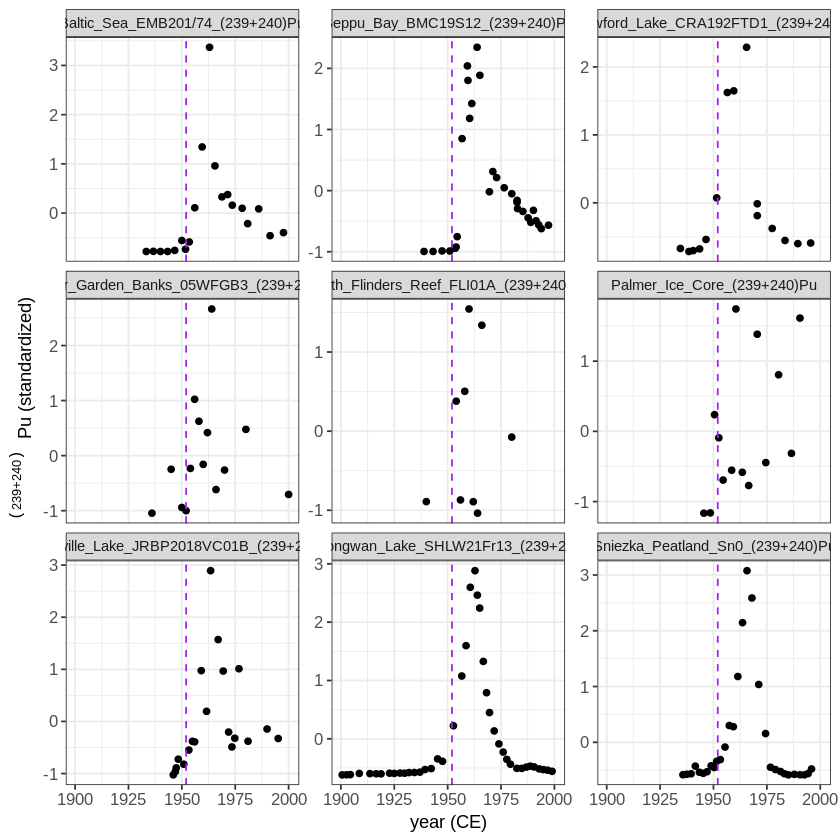

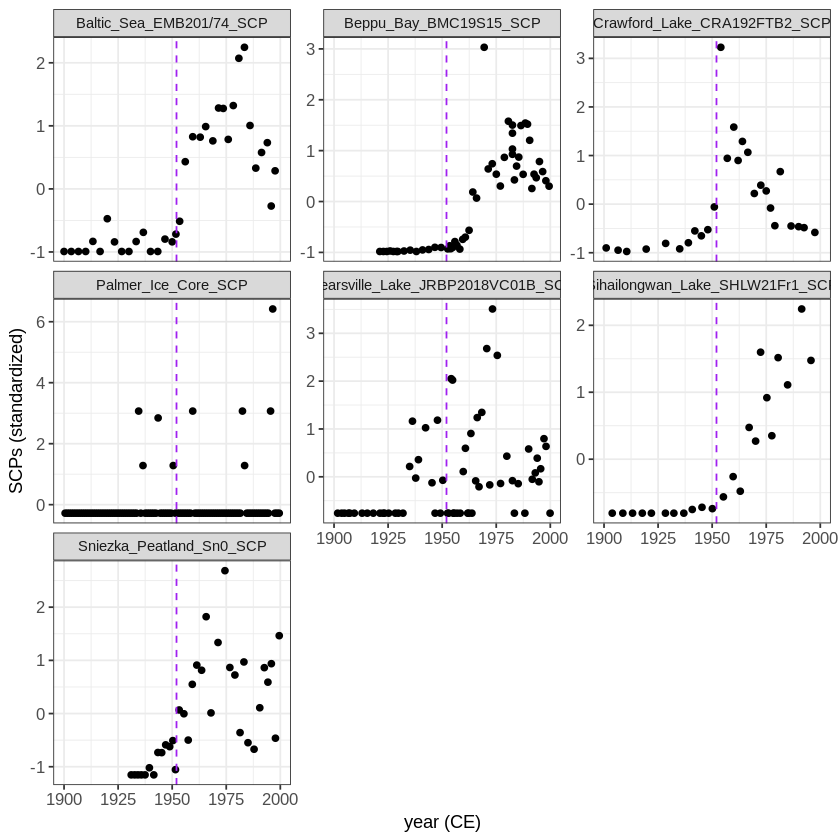

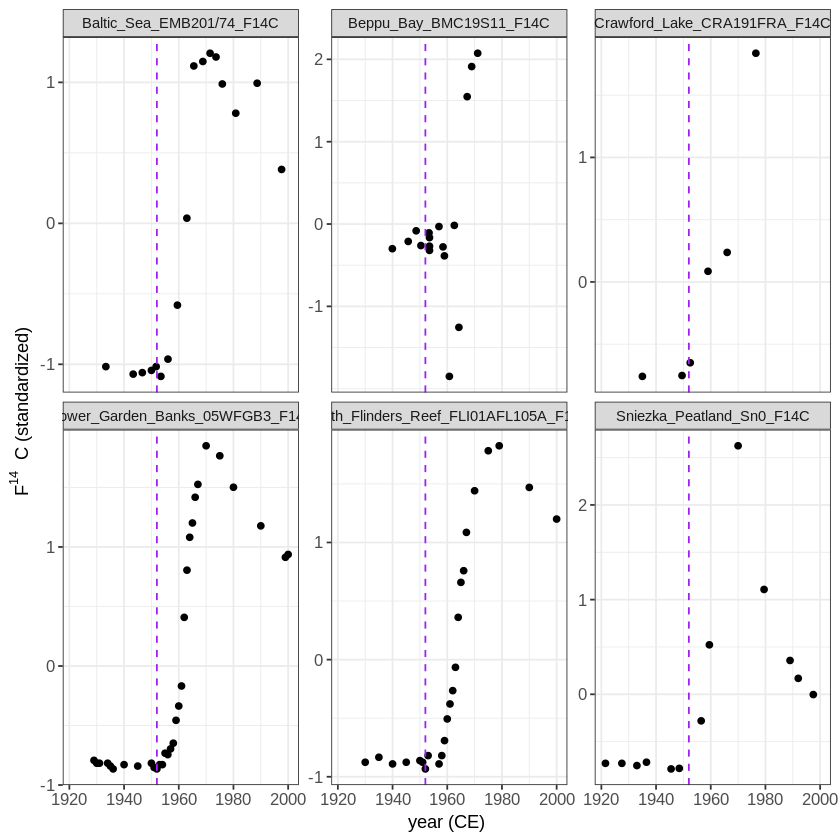

In [5]:
# Define the URL for the data
anthropocene_data_url_text <- paste(
  "https://raw.githubusercontent.com/",
  "zboraon/anthropocene_date/main/Data/",
  "anthropocene_data.csv",
  sep = ""
)

# Retrieve data from the URL
anthropocene_data_url <- getURL(anthropocene_data_url_text)

# Read the downloaded data into a data frame
datacombined <- read.csv(text = anthropocene_data_url)

# Remove rows with NA values in the 'proxy' column
datawoNA <- datacombined[!is.na(datacombined$proxy), ]

# Restrict the dataset to the 20th century interval (1900-2000)
datatouse_raw.index <- which(datawoNA$age <= 2000 & datawoNA$age >= 1900)
datatouse_raw <- datawoNA[datatouse_raw.index, ]
unique_proxynames <- unique(datatouse_raw$proxyname)
######################################################
pu_data <- subset(datatouse_raw, proxytype == "pu")
scp_data <- subset(datatouse_raw, proxytype == "scp")
f14c_data <- subset(datatouse_raw, proxytype == "f14c")

# Group by 'proxyname' and standardize 'proxy' within each group
pu_data_standardized_to_plot <- pu_data %>%
  group_by(proxyname) %>%
  mutate(standardized_pu = (proxy - mean(proxy)) / sd(proxy))

scp_data_standardized_to_plot <- scp_data %>%
  group_by(proxyname) %>%
  mutate(standardized_scp = (proxy - mean(proxy)) / sd(proxy))

f14c_data_standardized_to_plot <- f14c_data %>%
  group_by(proxyname) %>%
  mutate(standardized_f14c = (proxy - mean(proxy)) / sd(proxy))

pu_data_standardized_to_plot_names_changed <- pu_data_standardized_to_plot %>%
  mutate(proxyname = case_when(
    proxyname == "1.kaiser_239240Pu_EMB201/74" ~ "Baltic_Sea_EMB201/74_(239+240)Pu",
    proxyname == "2.kuwae_239240Pu_BMC19S12" ~ "Beppu_Bay_BMC19S12_(239+240)Pu",
    proxyname == "3.stegner_239240Pu_JRBP2018VC01B" ~ "Searsville_Lake_JRBP2018VC01B_(239+240)Pu",
    proxyname == "4.mccarthy_239240Pu_CRA192FTD1" ~ "Crawford_Lake_CRA192FTD1_(239+240)Pu",
    proxyname == "5.han_239240Pu_SHLW21Fr13" ~ "Sihailongwan_Lake_SHLW21Fr13_(239+240)Pu",
    proxyname == "6.zinke_239240Pu_FLI01A" ~ "North_Flinders_Reef_FLI01A_(239+240)Pu",
    proxyname == "7.delong_239240Pu_05WFGB3" ~ "Flower_Garden_Banks_05WFGB3_(239+240)Pu",
    proxyname == "8.thomas_239240Pu_palmer" ~ "Palmer_Ice_Core_(239+240)Pu",
    proxyname == "9.fialkiewiczKoziel_239240Pu_Sn0" ~ "Sniezka_Peatland_Sn0_(239+240)Pu",
    TRUE ~ proxyname
  ))

scp_data_standardized_to_plot_names_changed <- scp_data_standardized_to_plot %>%
  mutate(proxyname = case_when(
    proxyname == "1.kaiser_SCP_EMB201/74" ~ "Baltic_Sea_EMB201/74_SCP",
    proxyname == "2.kuwae_SCP_BMC19S15" ~ "Beppu_Bay_BMC19S15_SCP",
    proxyname == "3.stegner_SCP_JRBP2018VC01B" ~ "Searsville_Lake_JRBP2018VC01B_SCP",
    proxyname == "4.mccarthy_SCP_CRA192FTB2" ~ "Crawford_Lake_CRA192FTB2_SCP",
    proxyname == "5.han_SCP_SHLW21Fr1" ~ "Sihailongwan_Lake_SHLW21Fr1_SCP",
    proxyname == "8.thomas_SCP_palmer" ~ "Palmer_Ice_Core_SCP",
    proxyname == "9.fialkiewiczKoziel_SCP_Sn0" ~ "Sniezka_Peatland_Sn0_SCP",
    TRUE ~ proxyname
  ))

f14c_data_standardized_to_plot_names_changed <- f14c_data_standardized_to_plot %>%
  mutate(proxyname = case_when(
    proxyname == "1.kaiser_F14C_EMB201/74" ~ "Baltic_Sea_EMB201/74_F14C",
    proxyname == "2.kuwae_F14C_BG19S11" ~ "Beppu_Bay_BMC19S11_F14C",
    proxyname == "4.mccarthy_F14C_CRA191FRA" ~ "Crawford_Lake_CRA191FRA_F14C",
    proxyname == "6.zinke_F14C_FLI01A_FL105A" ~ "North_Flinders_Reef_FLI01AFL105A_F14C",
    proxyname == "7.delong_F14C_05WFGB3" ~ "Flower_Garden_Banks_05WFGB3_F14C",
    proxyname == "9.fialkiewiczKoziel_F14C_Sn0" ~ "Sniezka_Peatland_Sn0_F14C",
    TRUE ~ proxyname
  ))

ggplot(pu_data_standardized_to_plot_names_changed, aes(x = age, y = standardized_pu, group = proxytype)) +
  #geom_line(color = "black") +
  geom_point(color = "black") +
  geom_vline(xintercept = 1952, linetype = "dashed", color = "purple") +
  facet_wrap(~proxyname, scales = "free_y") +
  labs(#title = "Time Series Plot for Each Proxyname",
       x = "year (CE)",
       y = expression(" "^(239+240)~"Pu (standardized)")) +
  ggplot2::theme_bw() +
  theme(text= element_text(size=11), axis.text = element_text(size = 10))

ggplot(scp_data_standardized_to_plot_names_changed, aes(x = age, y = standardized_scp, group = proxytype)) +
  #geom_line(color = "black") +
  geom_point(color = "black") +
  geom_vline(xintercept = 1952, linetype = "dashed", color = "purple") +
  facet_wrap(~proxyname, scales = "free_y") +
  labs(#title = "Time Series Plot for Each Proxyname",
       x = "year (CE)",
       y = "SCPs (standardized)") +
  ggplot2::theme_bw() +
  theme(text= element_text(size=11), axis.text = element_text(size = 10))

ggplot(f14c_data_standardized_to_plot_names_changed, aes(x = age, y = standardized_f14c, group = proxytype)) +
  #geom_line(color = "black") +
  geom_point(color = "black") +
  geom_vline(xintercept = 1952, linetype = "dashed", color = "purple") +
  facet_wrap(~proxyname, scales = "free_y") +
  labs(#title = "Time Series Plot for Each Proxyname",
       x = "year (CE)",
       y = expression("F"^14~"C (standardized)")) +
  scale_y_continuous(breaks=c(-1, 0, 1, 2)) +
  ggplot2::theme_bw() +
  theme(text= element_text(size=11), axis.text = element_text(size = 10))


######################################################


# Create a vector of proxy names to remove
pu_to_remove <- c("6.zinke_239240Pu_FLI01A", "8.thomas_239240Pu_palmer")
scp_to_remove <- c("3.stegner_SCP_JRBP2018VC01B", "8.thomas_SCP_palmer")
f14c_to_remove <- c()


# Using the subset function
pu_datatouse <- subset(pu_data, !(proxyname %in% pu_to_remove))
scp_datatouse <- subset(scp_data, !(proxyname %in% scp_to_remove))
f14c_datatouse <- subset(f14c_data, !(proxyname %in% f14c_to_remove))


#####################################################
putousetibble <- as_tibble(pu_datatouse)
scptousetibble <- as_tibble(scp_datatouse)
f14ctousetibble <- as_tibble(f14c_datatouse)

# Imputation of the NA values in proxyerror column by a truncated normal distribution with mean=0 and sd=0.05*proxy value the

putousetibble_filled <- putousetibble %>%
  mutate(
    proxyerror_filled = ifelse(
      is.na(proxyerror),
      rtruncnorm(n = sum(is.na(proxyerror)), a = 0, mean = 0, sd = 0.05 * pmax(proxy, 10^(-9))),
      proxyerror
    ),
    ageerror_filled = ifelse(
      is.na(age.error),
      rtruncnorm(n = sum(is.na(age.error)), a = 0, mean = 0, sd = 0.5),
      age.error
    )
  )

scptousetibble_filled <- scptousetibble %>%
  mutate(
    proxyerror_filled = ifelse(
      is.na(proxyerror),
      rtruncnorm(n = sum(is.na(proxyerror)), a = 0, mean = 0, sd = 0.05 * pmax(proxy, 10^(-9))),
      proxyerror
    ),
    ageerror_filled = ifelse(
      is.na(age.error),
      rtruncnorm(n = sum(is.na(age.error)), a = 0, mean = 0, sd = 0.5),
      age.error
    )
  )

f14ctousetibble_filled <- f14ctousetibble %>%
  mutate(
    proxyerror_filled = ifelse(
      is.na(proxyerror),
      rtruncnorm(n = sum(is.na(proxyerror)), a = 0, mean = 0, sd = 0.05 * pmax(proxy, 10^(-9))),
      proxyerror
    ),
    ageerror_filled = ifelse(
      is.na(age.error),
      rtruncnorm(n = sum(is.na(age.error)), a = 0, mean = 0, sd = 0.5),
      age.error
    )
  )

######################

# Function to standardize a vector
standardize_vector <- function(x) {
  (x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE)
}

# Group by proxyname and apply standardization to proxy values
putousetibble_filled_standardized <- putousetibble_filled %>%
  group_by(proxyname) %>%
  mutate(standardized_proxy = standardize_vector(proxy)) %>%
  mutate(standardized_proxyerror = proxyerror_filled / sd(proxy))


# Rearrange columns of the tibble
putousetibble_filled_standardized <- putousetibble_filled_standardized %>%
  select(
    age, ageerror = age.error, ageerror_filled, proxy, standardized_proxy,
    proxyerror, proxyerror_filled, standardized_proxyerror,
    proxyname, researchername, comments
  )

# Group by proxyname and apply standardization to proxy values
scptousetibble_filled_standardized <- scptousetibble_filled %>%
  group_by(proxyname) %>%
  mutate(standardized_proxy = standardize_vector(proxy)) %>%
  mutate(standardized_proxyerror = proxyerror_filled / sd(proxy))


# Rearrange columns of the tibble
scptousetibble_filled_standardized <- scptousetibble_filled_standardized %>%
  select(
    age, ageerror = age.error, ageerror_filled, proxy, standardized_proxy,
    proxyerror, proxyerror_filled, standardized_proxyerror,
    proxyname, researchername, comments
  )

# Group by proxyname and apply standardization to proxy values
f14ctousetibble_filled_standardized <- f14ctousetibble_filled %>%
  group_by(proxyname) %>%
  mutate(standardized_proxy = standardize_vector(proxy)) %>%
  mutate(standardized_proxyerror = proxyerror_filled / sd(proxy))


# Rearrange columns of the tibble
f14ctousetibble_filled_standardized <- f14ctousetibble_filled_standardized %>%
  select(
    age, ageerror = age.error, ageerror_filled, proxy, standardized_proxy,
    proxyerror, proxyerror_filled, standardized_proxyerror,
    proxyname, researchername, comments
  )

listofcp1s <- rep(NA, length(unique_proxynames))
names(listofcp1s) <- unique_proxynames

listofcp2s <- rep(NA, length(unique_proxynames))
names(listofcp2s) <- unique_proxynames


# Finding the second change point and truncate data

Adding missing grouping variables: `proxyname`


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 35
   Unobserved stochastic nodes: 8
   Total graph size: 698

Initializing model



Finished sampling in 4.9 seconds




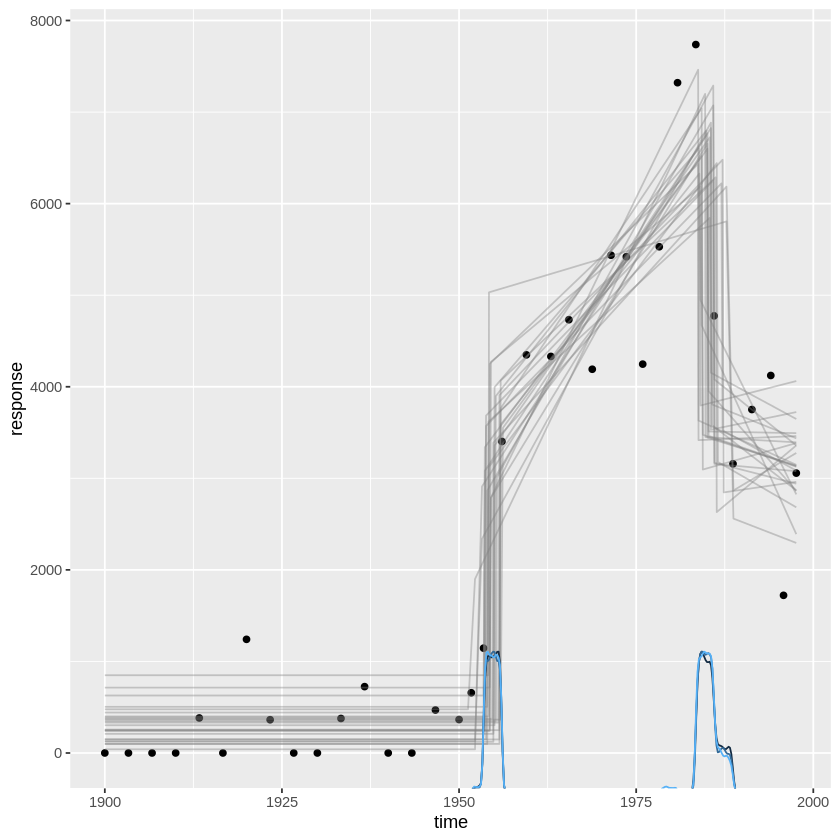

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 29
   Unobserved stochastic nodes: 5
   Total graph size: 402

Initializing model



Finished sampling in 2.2 seconds




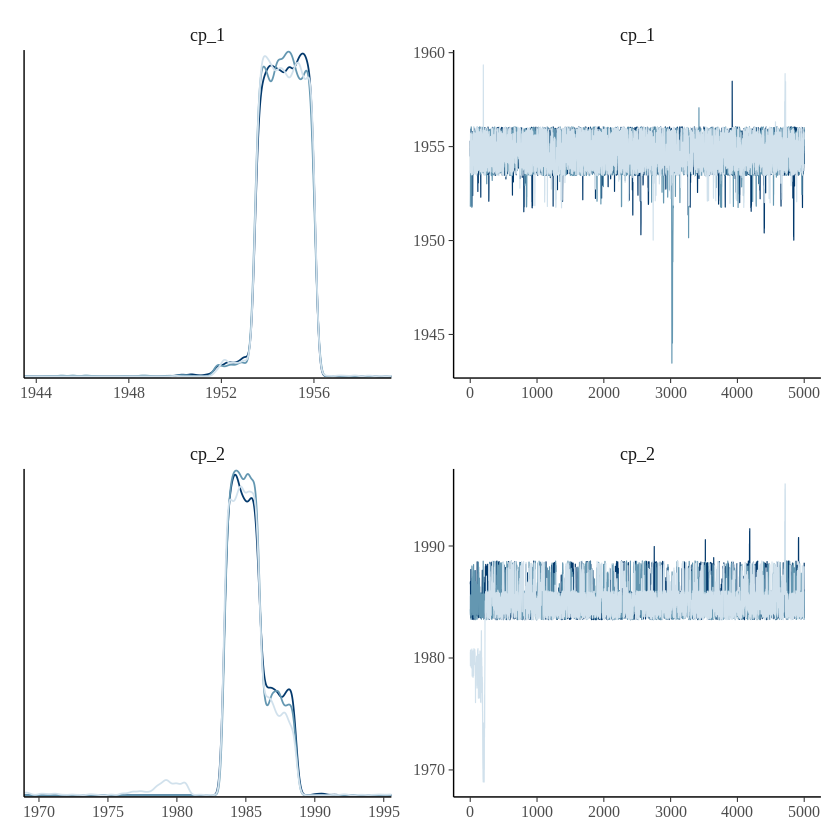

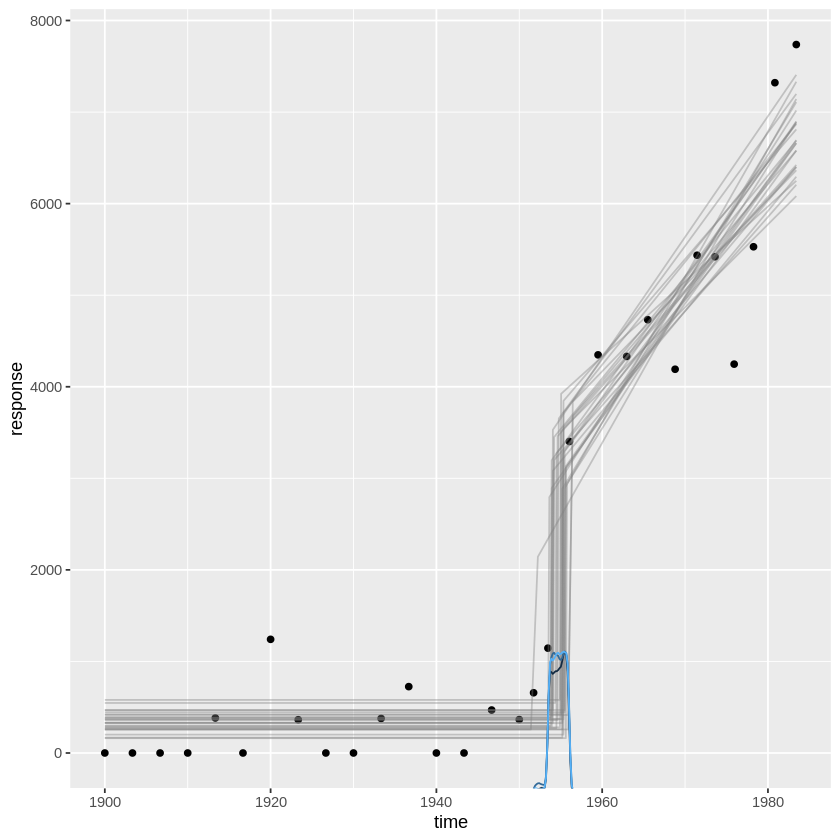

Adding missing grouping variables: `proxyname`


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 55
   Unobserved stochastic nodes: 6
   Total graph size: 736

Initializing model



Finished sampling in 5.6 seconds




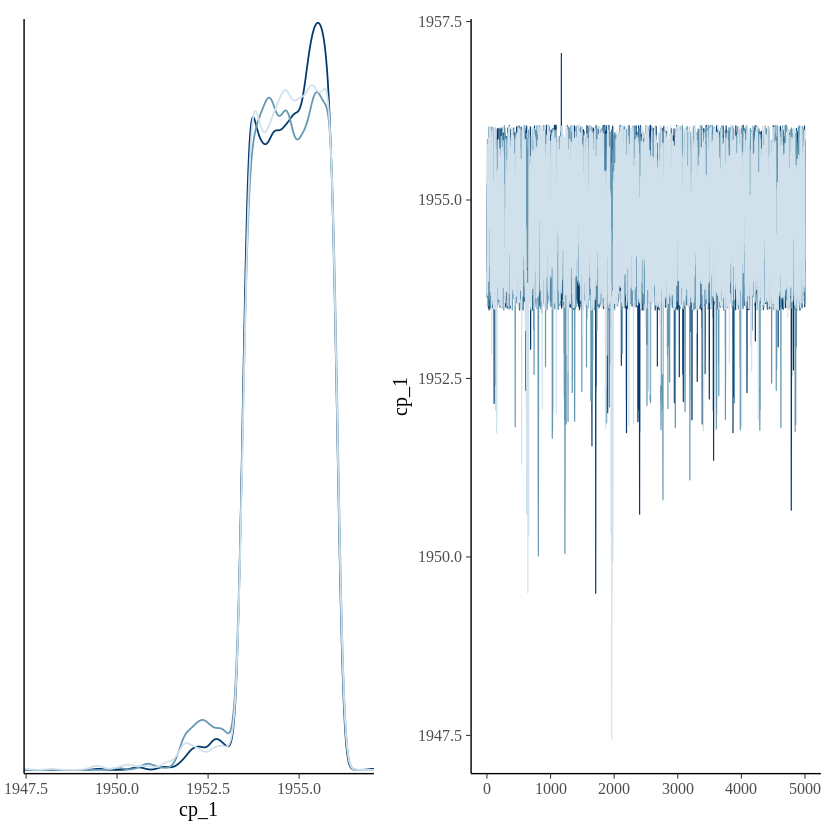

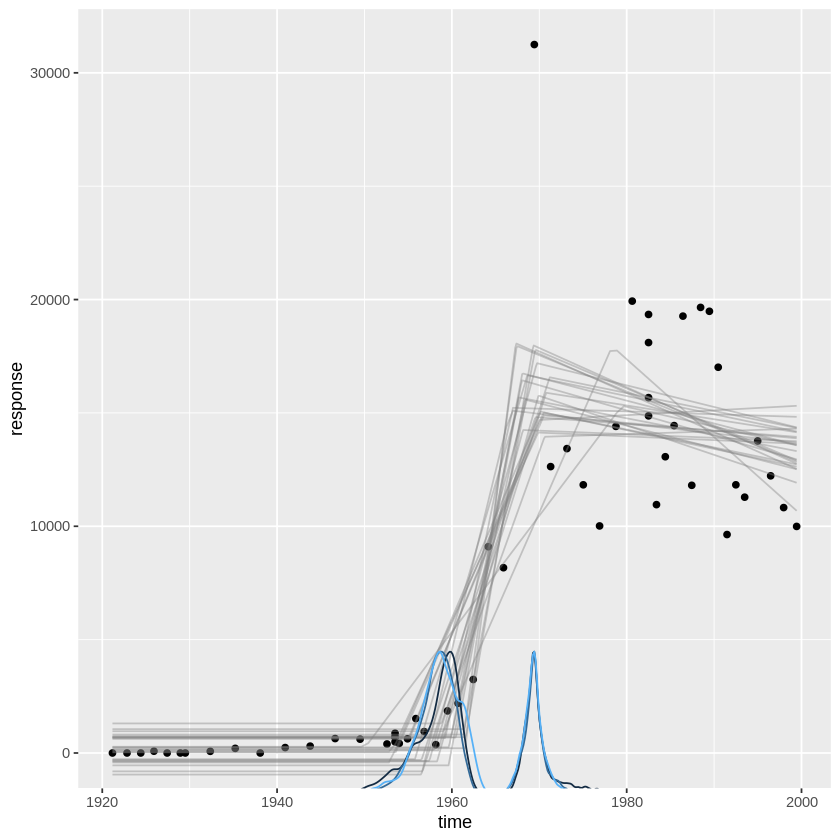

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 5
   Total graph size: 385

Initializing model



Finished sampling in 2.2 seconds




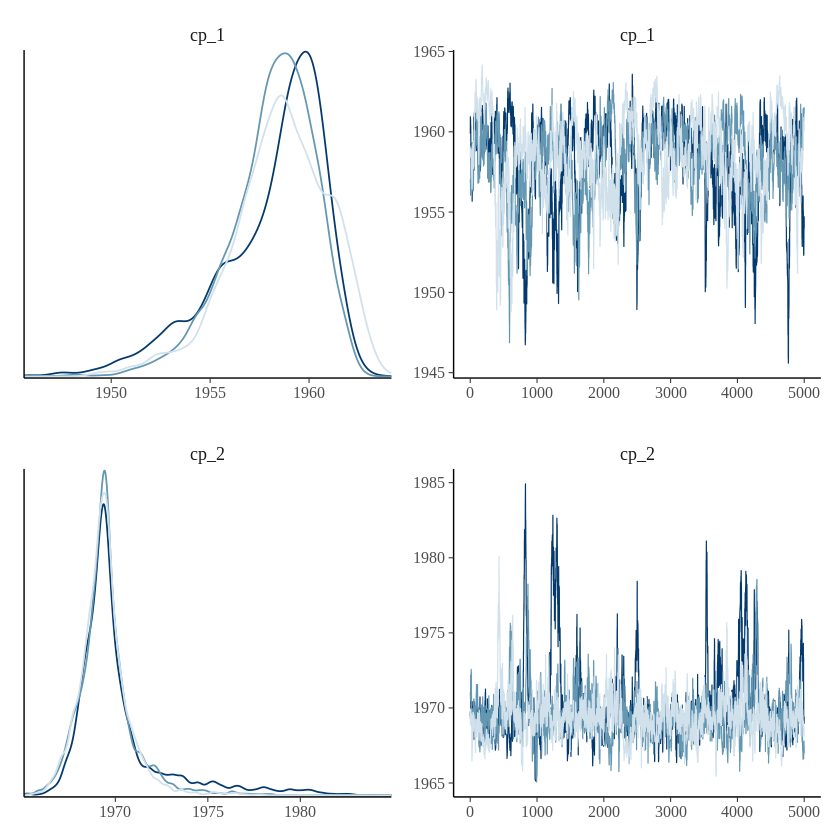

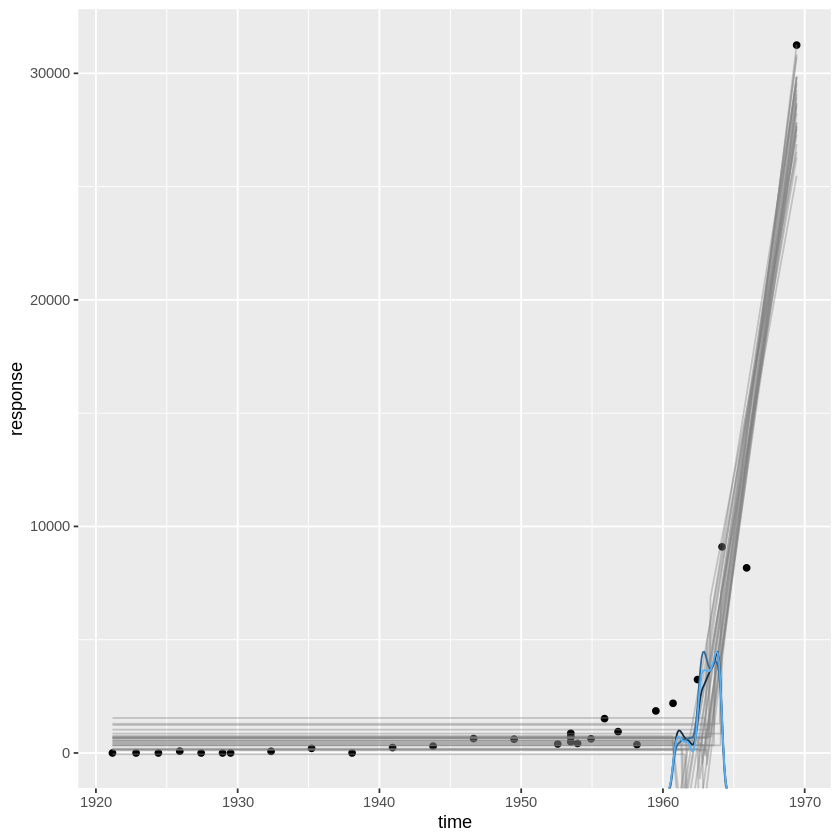

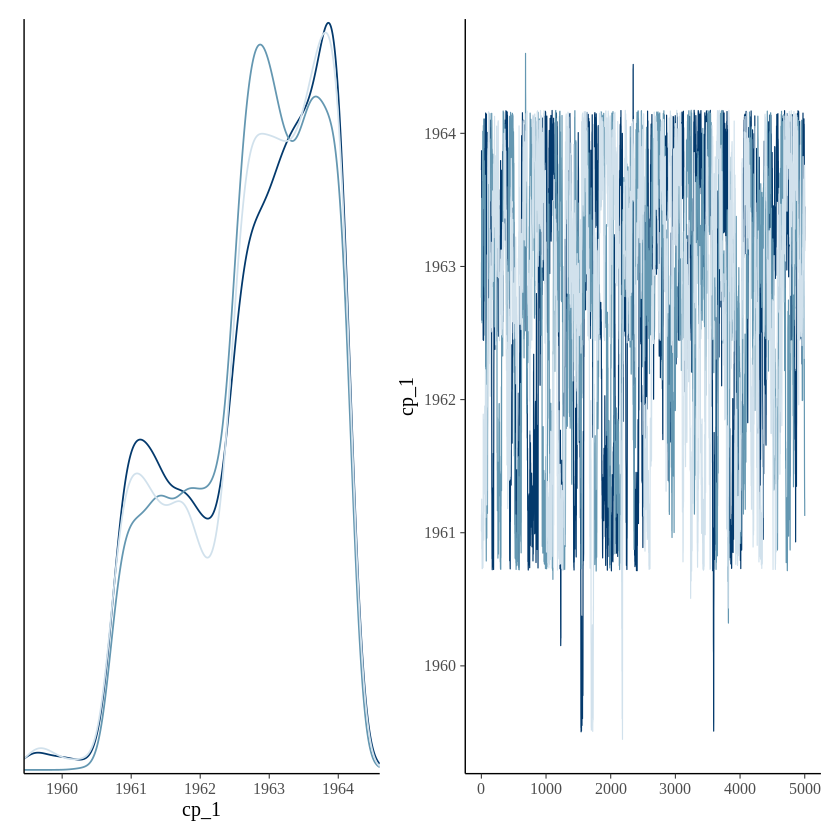

In [6]:
# number of iterations and adaptations
iter = 5000
adapt = 5000

##############################

# Kaiserscp model

kaiserscp <- scptousetibble_filled_standardized %>%
  filter(proxyname == "1.kaiser_SCP_EMB201/74") %>%
  select(time = age, response = proxy)

data_clean_kaiserscp <- na.omit(kaiserscp)

model8_kaiserscp = list(
  response ~ 1 ,  # plateau (int_1)
  ~ 1 + time ,
  ~ 1 + time
)
fit8_kaiserscp = mcp(model8_kaiserscp, data = data_clean_kaiserscp, iter = iter, adapt = adapt)
plot(fit8_kaiserscp)
plot_pars(fit8_kaiserscp, regex_pars = "cp_")

# Assign the summary of the model to summarykaiser1
summarykaiserscp <- fixef(fit8_kaiserscp)

# Convert the first column to row names
rownames(summarykaiserscp) <- summarykaiserscp$name

# Remove the first column (name) since it is now the row names
summarykaiserscp <- summarykaiserscp[, -1]

# Select the time value for the data to be cut
data_clean_cut_kaiserscp <- data_clean_kaiserscp[ data_clean_kaiserscp$time<=summarykaiserscp["cp_2", "mean"], ]

modelfinallinekaiserscp = list(
  response ~ 1,  # int_1
  ~ 1 + time  # cp_1, cp_1_sd, cp_1_id[i]
)

fitfinallinekaiserscp = mcp(modelfinallinekaiserscp, data = data_clean_cut_kaiserscp, iter = iter, adapt = adapt)
plot(fitfinallinekaiserscp)
plot_pars(fitfinallinekaiserscp, regex_pars = "cp_")

listofcp1s["1.kaiser_SCP_EMB201/74"] <- summarykaiserscp["cp_1", "mean"]
listofcp2s["1.kaiser_SCP_EMB201/74"] <- summarykaiserscp["cp_2", "mean"]

##############################

# Kuwaescp model

kuwaescp <- scptousetibble_filled_standardized %>%
  filter(proxyname == "2.kuwae_SCP_BMC19S15") %>%
  select(time = age, response = proxy)

data_clean_kuwaescp <- na.omit(kuwaescp)

model8_kuwaescp = list(
  response ~ 1 ,  # plateau (int_1)
  ~ 0 + time ,
  ~ 0 + time
)
fit8_kuwaescp = mcp(model8_kuwaescp, data = data_clean_kuwaescp, iter = iter, adapt = adapt)
plot(fit8_kuwaescp)
plot_pars(fit8_kuwaescp, regex_pars = "cp_")

# Assign the summary of the model to summarykaiser1
summarykuwaescp <- fixef(fit8_kuwaescp)

# Convert the first column to row names
rownames(summarykuwaescp) <- summarykuwaescp$name

# Remove the first column (name) since it is now the row names
summarykuwaescp <- summarykuwaescp[, -1]

# Select the time value for the data to be cut
data_clean_cut_kuwaescp <- data_clean_kuwaescp[ data_clean_kuwaescp$time<=summarykuwaescp["cp_2", "mean"], ]

modelfinallinekuwaescp = list(
  response ~ 1,  # int_1
  ~ 1 + time  # cp_1, cp_1_sd, cp_1_id[i]
)

fitfinallinekuwaescp = mcp(modelfinallinekuwaescp, data = data_clean_cut_kuwaescp, iter = iter, adapt = adapt)
plot(fitfinallinekuwaescp)
plot_pars(fitfinallinekuwaescp, regex_pars = "cp_")

listofcp1s["2.kuwae_SCP_BMC19S15"] <- summarykuwaescp["cp_1", "mean"]
listofcp2s["2.kuwae_SCP_BMC19S15"] <- summarykuwaescp["cp_2", "mean"]



##############################

listofcp1s["1.kaiser_SCP_EMB201/74"] <- summarykaiserscp["cp_1", "mean"]
listofcp2s["1.kaiser_SCP_EMB201/74"] <- summarykaiserscp["cp_2", "mean"]
listofcp1s["2.kuwae_SCP_BMC19S15"] <- summarykuwaescp["cp_1", "mean"]
listofcp2s["2.kuwae_SCP_BMC19S15"] <- summarykuwaescp["cp_2", "mean"]



# Find names containing "SCP"
scp_matching_names <- grep("SCP", names(listofcp2s), value = TRUE)

# Extract the corresponding values and calculate the mean
min_of_evaluated_scps <- min(listofcp2s[scp_matching_names], na.rm = TRUE)

# Replace NA values with the mean_of_matching for names containing "SCP"
listofcp2s_filled <- listofcp2s
names_to_fill <- grep("SCP", names(listofcp2s_filled), value = TRUE)
listofcp2s_filled[names_to_fill] <- ifelse(is.na(listofcp2s_filled[names_to_fill]), min_of_evaluated_scps, listofcp2s_filled[names_to_fill])


# Filter the tibble
filtered_scpdatatouse <- scptousetibble_filled_standardized %>%
  filter(age <= listofcp2s_filled[as.character(proxyname)])



id_column <- as.numeric(factor(filtered_scpdatatouse$proxyname, levels = unique(filtered_scpdatatouse$proxyname)))

# Create a new column with corresponding values
filtered_scpdatatouse <- cbind(filtered_scpdatatouse, id_column = id_column)


########################################################3



# The jags model

In [7]:
library("tibble")
library("dplyr")
library("runjags")

filtered_datatouse_selected_for_jags <- filtered_scpdatatouse %>%
  select(age, id_column, standardized_proxy, standardized_proxyerror, ageerror_filled) %>%
  rename(age = age, id = id_column, y = standardized_proxy, proxyerror = standardized_proxyerror, ageerror = ageerror_filled) %>%
  mutate(proxyerror = ifelse(proxyerror == 0, proxyerror + 1e-10, proxyerror)) %>%
  mutate(ageerror = ifelse(ageerror == 0, ageerror + 1e-10, ageerror)) #%>%
dataList_forjags <- as.list(filtered_datatouse_selected_for_jags[,-1])
dataList_forjags$minx <- min(filtered_datatouse_selected_for_jags$age)
dataList_forjags$maxx <- max(filtered_datatouse_selected_for_jags$age)
#dataList_forjags$SDY <- sd(filtered_datatouse_selected_for_jags$y)


modelString <- "
data {
  for (tr_ in 1:length(age)) {
  age_tr[tr_] <- age[tr_] / 1000
  ageerror_tr[tr_] <- ageerror[tr_] / 1000
  }
  MINX <- minx / 1000
  MAXX <- maxx / 1000
}
model {
  # Priors for population-level effects
  cp_1_tr ~ dt(mu_cp_1, 1/sigma_cp_1^2, nu_cp)T(MINX, MAXX)
  sigma_cp_1 ~ dt(0, 0.05^(-2), 1)T(0, )

  int_1 ~ dt(0, 5^(-2), 3)
  x_2_tr ~ dt(0, 100^(-2), 3)
  sigma_1 ~  dt(0, 5^(-2), 1)T(0, )
  mu_cp_1 ~ dunif(MINX,MAXX) #dnorm(1.950, 1^(-2))T(MINX, MAXX)

  nu_cp ~ dexp(1/30)

  # Priors for varying effects
  for (id_ in 1:max(id)) {
    cp_1_id_tr_uncentered[id_] ~ dt(0, 1/cp_1_sigma_tr^2,5) T(MINX - cp_1_tr, MAXX - cp_1_tr)
  }
  cp_1_id_tr <- cp_1_id_tr_uncentered - mean(cp_1_id_tr_uncentered)  # vectorized zero-centering
  cp_1_sigma_tr ~ dt(0, 0.05^(-2), 1)T(0, )

  # Model and likelihood
  for (i_ in 1:length(age_tr)) {
    X_1_[i_] <- min(trueage[i_], (cp_1_tr + cp_1_id_tr[id[i_]]))
    X_2_[i_] <- min(trueage[i_], MAXX) - (cp_1_tr + cp_1_id_tr[id[i_]])
    trueage[i_] ~ dunif(MINX,MAXX) #dnorm(0, 1^(-2))
    age_tr[i_] ~  dnorm(trueage[i_], 1 / ageerror_tr[i_]^2)

    # Fitted value
    y_[i_] =

      # Segment 1: y ~ 1 + x
      (trueage[i_] >= MINX) * int_1 +

      # Segment 2: y ~ 1 + (1 | id) ~ 0 + x
      (trueage[i_]>= (cp_1_tr + cp_1_id_tr[id[i_]])) * x_2_tr * X_2_[i_]

    # Fitted standard deviation
    tau_y_[i_] = (proxyerror[i_]^2 + (sigma_1)^2)^(-1)

    # Likelihood
    y[i_] ~  dnorm(y_[i_], tau_y_[i_]) # dnorm(y_[i_], tau_y_[i_])  # dt(y_[i_], tau_y_[i_], nu_y) #
  }
  # Transform to original scale:
  cp_1 <- cp_1_tr * 1000
  cp_1_id <- cp_1_id_tr * 1000
  cp_1_sd <- cp_1_sigma_tr * 1000
  x_2 <- x_2_tr / 1000
}
  "

sampleNO <- 20000
thinstepsNO <- 2
adaptNO <- 20000
burninNO <- 20000
nChains <- 3


writeLines(modelString, con="TEMPmodel.txt")
parameters <- c("cp_1", "cp_1_id", "cp_1_sd", "int_1", "sigma_1", "x_2", "cp_1_sd")


# run the model
runJagsOut_scp <- run.jags(method = "parallel",
                       model = "TEMPmodel.txt",
                       monitor = parameters,
                       data = dataList_forjags,
                       n.chains = nChains,
                       adapt = adaptNO,
                       burnin = burninNO,
                       sample = sampleNO,
                       thin = thinstepsNO,
                       summarise = FALSE,
                       plots = FALSE,
                       modules = 'glm')



Adding missing grouping variables: `proxyname`
Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 2 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.2 on Mon Feb  5 18:26:10 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. Loading module: glm: ok
. . Reading data file data.txt
. Compiling data graph
   Resolving undeclared variables
   Allocating nodes
   Initializing
   Reading data back into data table
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 226
   Unobserved stochastic nodes: 126
   Total graph size: 2195
. Reading parameter file inits1.txt
. Reading parameter file inits3.txt
. Initializing model
. Adapting 20000
-------------------------------------------------| 20000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation successful
. Updating 20000
--------------------------------------------

In [8]:
      codaSamples <- as.mcmc.list(runJagsOut_scp)
      save(runJagsOut_scp, file="anthropocene_cp_scp_MCMC.Rdata" )
      summary2023colabrun_scp <- summary(runJagsOut_scp)
      write.csv(summary2023colabrun_scp, "/content/summary_sim_runs_scp.csv")

Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 10 variables....
